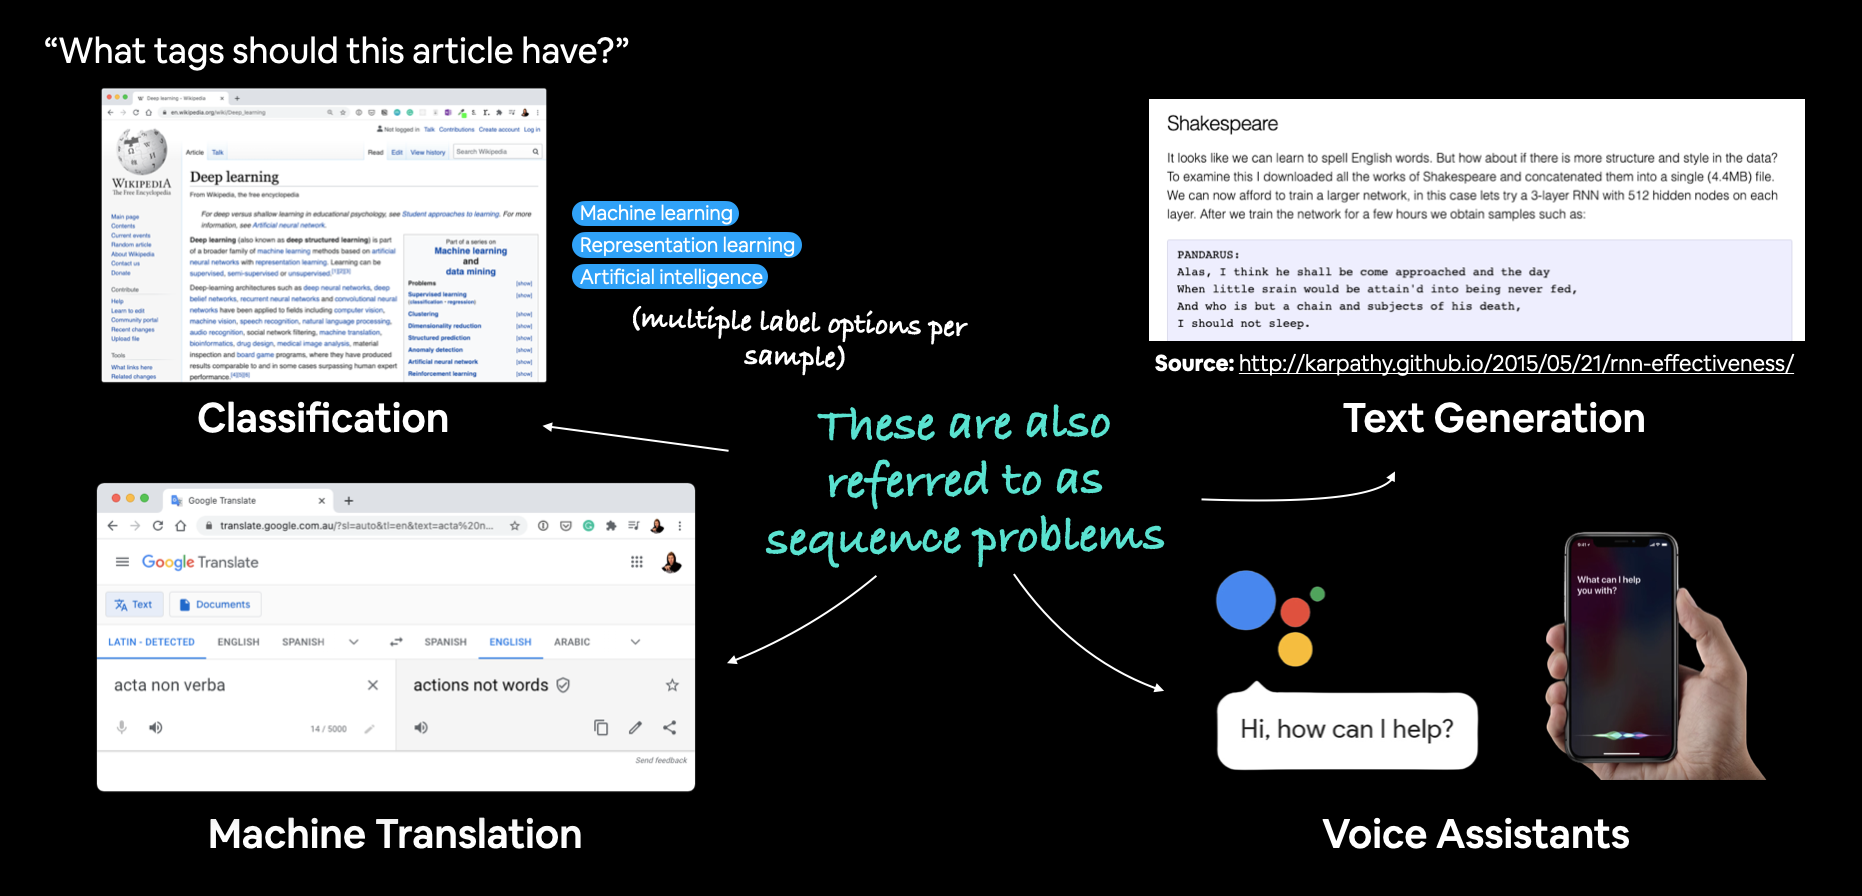

The main goal of NLP is to derive information from natural language.

Text -> turn into numbers -> build a model -> train the model to find patterns -> use patterns (make predictions)


* Downloading a text dataset
* Visualizing text data
* Converting text into numbers using tokenization
* Turning our tokenized text into an embedding
* Modelling a text dataset
  * Starting with a baseline (TF-IDF)
  * Building several deep learning text models
    * Dense, LSTM, GRU, Conv1D, Transfer learning
* Comparing the performance of each our models
* Combining our models into an ensemble
* Saving and loading a trained model
* Find the most wrong predictions

In [1]:
import datetime
print(f"Notebook last run at {datetime.datetime.now()}")

Notebook last run at 2025-08-11 23:37:01.198255


In [2]:
!nvidia-smi

Mon Aug 11 23:37:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.43                 Driver Version: 566.43         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   48C    P3             16W /   40W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

Downloading a text dataset: Text based Tweets about natural disasters

In [4]:
import wget
import zipfile

url = "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"
filename = wget.download(url)  # This will save in current directory

# Unzip data
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()  # Extract into current directory


Visualizing a text data

In [5]:
import pandas as pd
train_df=pd.read_csv("train.csv")
test_df=pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df_shuffled = train_df.sample(frac=1, random_state=42)  # Shuffle the DataFrame
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


Inputs (text column) -> Machine Learning Algorithm -> Outputs (target column)


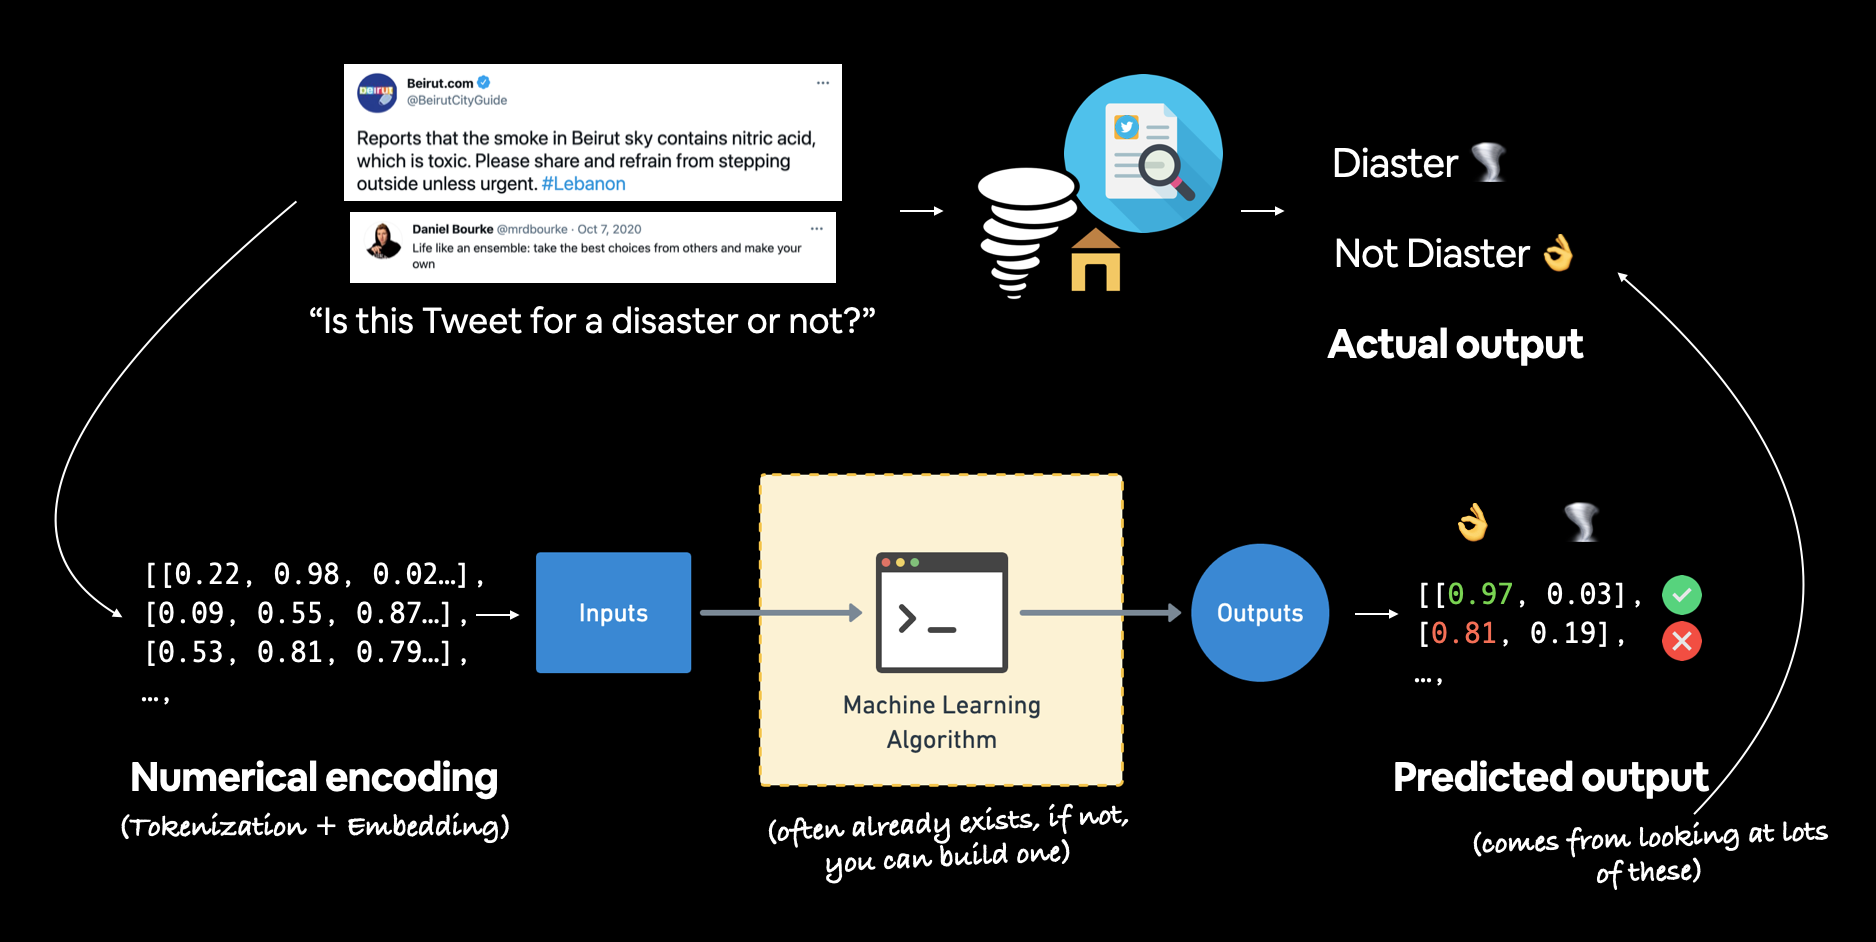

In [7]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [9]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [10]:
import random

random_index=random.randint(0,len(train_df)-5)

for row in train_df_shuffled[["text","target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Text: {text}\nTarget: {target}\n")

Text: #TrainTragedy - Happened in MP due to collapse of bridge now I m afraid to take a long distance train. http://t.co/JthusynJaH
Target: 1

Text: In the beginning of summer my mom made my curfew 1 now it's back to 12 and I can never go out and she wonders why I'm always at home
Target: 0

Text: August 5 1620 one hundred-odd pilgrims from England and Holland set sail for the New World. They were unimpressed. http://t.co/pW5DSt9ROz
Target: 0

Text: CANADA BC DROUGHT: Okanagan region issued Level 4 rating - Okanagan River (Columbia trib) fishing suspended to Sep 30 http://t.co/r4yZHxk7lw
Target: 1

Text: @AWickedAssassin want to burst into flames! *Anna hugged him tightly*
Target: 0



Split data into training and validation sets

In [11]:
from sklearn.model_selection import train_test_split

train_sentences , val_sentences, train_labels, val_labels= train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [12]:
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [13]:
train_sentences[:5], train_labels[:5], val_sentences[:5], val_labels[:5]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
       dtype=object),
 array([0, 0, 1, 0, 0]),
 array(['DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5',
        'FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday',
        'Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj',
        '@camilacabello97 Internally and externally screaming',
        'Radiation emergency #preparedness starts with knowing to: g

Converting text into numbers

In NLP, there are two main concepts for turning text into numbers:

* Tokenization - A straight mapping from word or character or sub-word to a numerical value. There are three main levels of tokenization:
  * a. Using word-level tokenization with the sentence "I love TensorFlow" might result in "I" being 0, "love" being 1 and "TensorFlow" being 2. In this case, every word in a sequence considered a single token.
  * b. Character-level tokenization, such as converting the letters A-Z to values 1-26. In this case, every character in a sequence considered a single token.
  * c. Sub-word tokenization is in between word-level and character-level tokenization. It involves breaking individual words into smaller parts and then converting those smaller parts into numbers. For example, "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". After doing this, these sub-words would then be mapped to a numerical value. In this case, every word could be considered multiple tokens.
* Embeddings - An embedding is a representation of natural language which can be learned. Representation comes in the form of a feature vector. For example, the word "dance" could be represented by the 5-dimensional vector [-0.8547, 0.4559, -0.3332, 0.9877, 0.1112]. It's important to note here, the size of the feature vector is tuneable. There are two ways to use embeddings:
  * a. Create your own embedding - Once your text has been turned into numbers (required for an embedding), you can put them through an embedding layer (such as tf.keras.layers.Embedding) and an embedding representation will be learned during model training.
  * b. Reuse a pre-learned embedding - Many pre-trained embeddings exist online. These pre-trained embeddings have often been learned on large corpuses of text (such as all of Wikipedia) and thus have a good underlying representation of natural language. You can use a pre-trained embedding to initialize your model and fine-tune it to your own specific task.


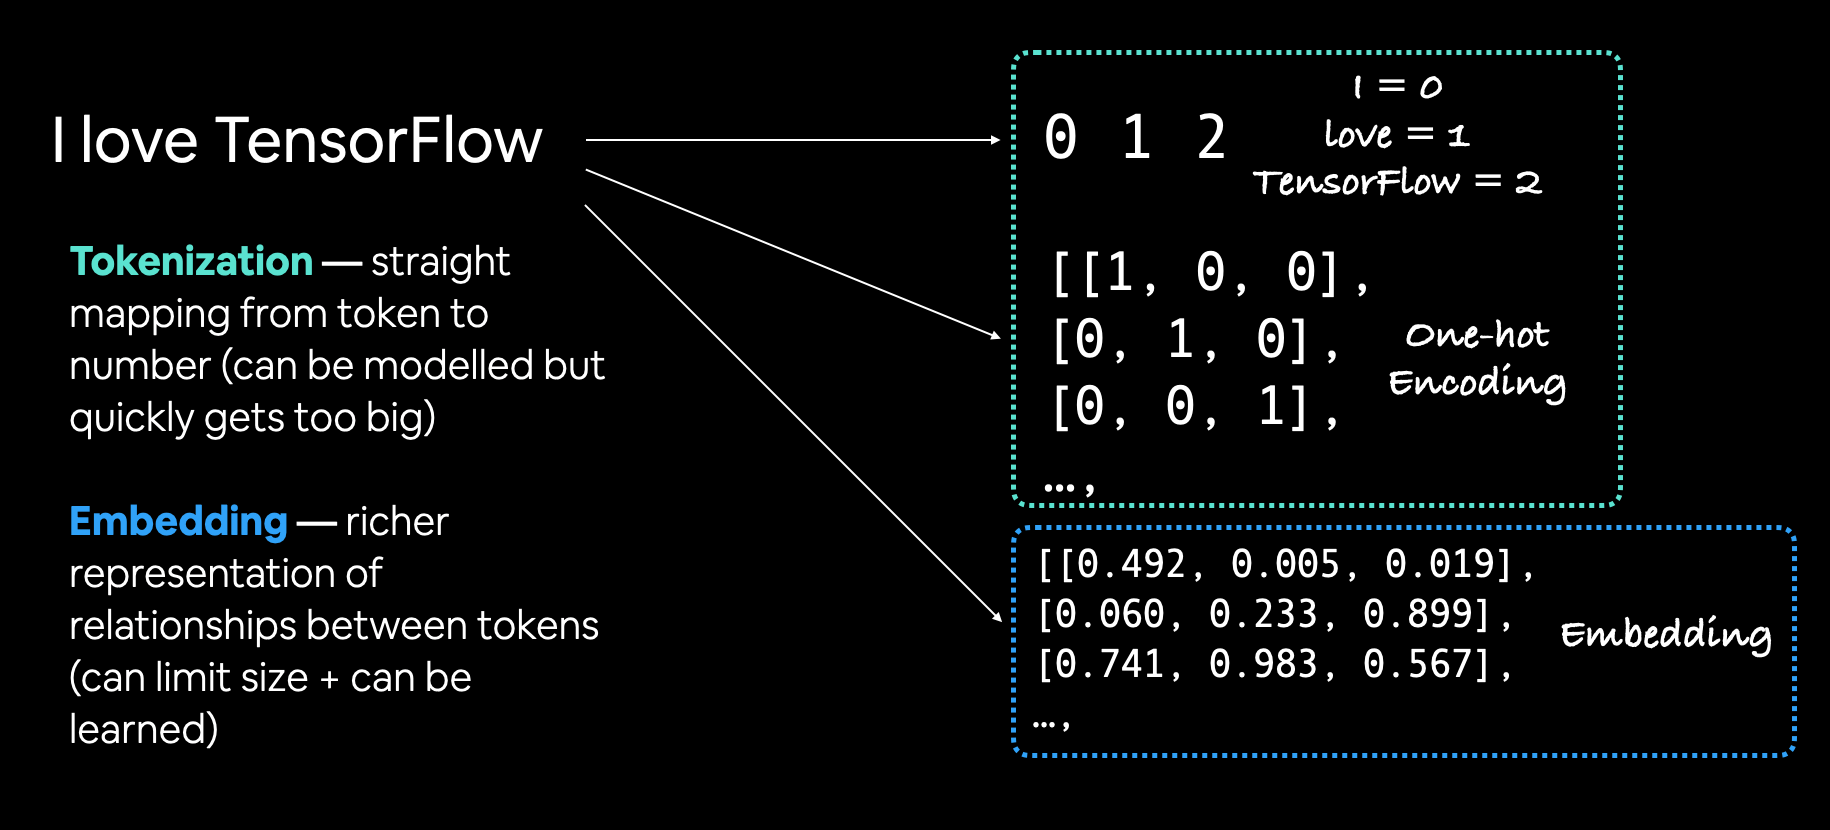

Question: What level of tokenzation should I use? What embedding should should I choose?

It depends on the problem. We could try character-level tokenization/embeddings and word-level tokenization/embeddings and see which perform best. We might even want to try stacking them (e.g. combining the outputs of your embedding layers using tf.keras.layers.concatenate).

If we're looking for pre-trained word embeddings, Word2vec embeddings, GloVe embeddings and many of the options available on TensorFlow Hub are great places to start.

Text Vectorization(tokeniation)

To tokenize our words, we'll use the helpful preprocessing layer tf.keras.layers.experimental.preprocessing.TextVectorization.

The TextVectorization layer takes the following parameters:

* max_tokens - The maximum number of words in your vocabulary (e.g. 20000 or the number of unique words in your text), includes a value for OOV (out of vocabulary) tokens.
* standardize - Method for standardizing text. Default is "lower_and_strip_punctuation" which lowers text and removes all punctuation marks.
* split - How to split text, default is "whitespace" which splits on spaces.
* ngrams - How many words to contain per token split, for example, ngrams=2 splits tokens into continuous sequences of 2.
* output_mode - How to output tokens, can be "int" (integer mapping), "binary" (one-hot encoding), "count" or "tf-idf". See documentation for more.
* output_sequence_length - Length of tokenized sequence to output. For example, if output_sequence_length=150, all tokenized sequences will be 150 tokens long.
* pad_to_max_tokens - Defaults to False, if True, the output feature axis will be padded to max_tokens even if the number of unique tokens in the vocabulary is less than max_tokens. Only valid in certain modes, see docs for more.

In [14]:
import tensorflow as tf

from tensorflow.keras.layers import TextVectorization

text_vectorizer=TextVectorization(
    max_tokens=None,
    standardize="lower_and_strip_punctuation",
    split="whitespace", 
    ngrams=None,
    output_mode="int",  
    output_sequence_length=None,
    pad_to_max_tokens=False
)

In [15]:
# find the average number of tokens in out training sentences

round(sum([len(i.split()) for i in train_sentences])/len(train_sentences) )

15

In [16]:
max_vocab_length = 10000  # Set a maximum vocabulary length
max_length=15
text_vectorizer=TextVectorization(
    max_tokens=max_vocab_length,
    standardize="lower_and_strip_punctuation",
    split="whitespace", 
    ngrams=None,
    output_mode="int",  
    output_sequence_length=max_length,
    pad_to_max_tokens=False
)

To map our TextVectorization instance text_vectorizer to our data, we can call the adapt() method on it whilst passing it our training text.

In [17]:
text_vectorizer.adapt(train_sentences)

In [18]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [19]:
random_sentence=random.choice(train_sentences)

print(f"Original sentence: {random_sentence}")
print(f"Tokenized sentence: {text_vectorizer([random_sentence])}")

Original sentence: HTML5 Beginners Crash Course http://t.co/Y32oWBroVF #course http://t.co/Vr2U4cErW8
Tokenized sentence: [[   1 4102   85  781    1  781    1    0    0    0    0    0    0    0
     0]]


we can check the unique tokens in our vocabulary using the get_vocabulary() method.

In [20]:
words_in_vocab=text_vectorizer.get_vocabulary()
len(words_in_vocab)


10000

In [21]:
words_in_vocab

['',
 '[UNK]',
 np.str_('the'),
 np.str_('a'),
 np.str_('in'),
 np.str_('to'),
 np.str_('of'),
 np.str_('and'),
 np.str_('i'),
 np.str_('is'),
 np.str_('for'),
 np.str_('on'),
 np.str_('you'),
 np.str_('my'),
 np.str_('with'),
 np.str_('it'),
 np.str_('that'),
 np.str_('at'),
 np.str_('by'),
 np.str_('this'),
 np.str_('from'),
 np.str_('be'),
 np.str_('are'),
 np.str_('was'),
 np.str_('have'),
 np.str_('like'),
 np.str_('as'),
 np.str_('up'),
 np.str_('so'),
 np.str_('just'),
 np.str_('but'),
 np.str_('me'),
 np.str_('im'),
 np.str_('your'),
 np.str_('not'),
 np.str_('amp'),
 np.str_('out'),
 np.str_('its'),
 np.str_('will'),
 np.str_('an'),
 np.str_('no'),
 np.str_('has'),
 np.str_('fire'),
 np.str_('after'),
 np.str_('all'),
 np.str_('when'),
 np.str_('we'),
 np.str_('if'),
 np.str_('now'),
 np.str_('via'),
 np.str_('new'),
 np.str_('more'),
 np.str_('get'),
 np.str_('or'),
 np.str_('about'),
 np.str_('what'),
 np.str_('he'),
 np.str_('people'),
 np.str_('news'),
 np.str_('been'),
 n

In [22]:
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")


Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', np.str_('the'), np.str_('a'), np.str_('in')]
Bottom 5 least common words: [np.str_('pages'), np.str_('paeds'), np.str_('pads'), np.str_('padres'), np.str_('paddytomlinson1')]


Creating an Embedding using an Embedding Layer

The main parameters we're concerned about here are:

* input_dim - The size of the vocabulary (e.g. len(text_vectorizer.get_vocabulary()).
* output_dim - The size of the output embedding vector, for example, a value of 100 outputs a feature vector of size 100 for each word.
* embeddings_initializer - How to initialize the embeddings matrix, default is "uniform" which randomly initalizes embedding matrix with uniform distribution. This can be changed for using pre-learned embeddings.
* input_length - Length of sequences being passed to embedding layer.

In [23]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding=layers.Embedding(
    input_dim=max_vocab_length,  # Size of the vocabulary
    output_dim=128,  # Size of the output embedding vector
    embeddings_initializer="uniform",  # How to initialize the embeddings matrix    
    name="embedding_1",  # Name of the layer
)

In [24]:
random_sentence=random.choice(train_sentences)
print(f"Original sentence: {random_sentence}")
sampled_sentence=embedding(text_vectorizer([random_sentence]))
sampled_sentence


Original sentence: HEALTH FACT: 75% of muscle mass is made up of fluid. Drink water to prevent strains sprains and other injuries. http://t.co/g0dN1ChLUo


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.01196271,  0.04960039,  0.03846784, ..., -0.03260233,
         -0.03401103, -0.00028319],
        [ 0.04714062, -0.00973694, -0.0111498 , ..., -0.03834814,
         -0.01455241,  0.01596776],
        [-0.03310593,  0.00791537,  0.00510054, ..., -0.01085696,
         -0.04453927,  0.03173292],
        ...,
        [ 0.01273096, -0.04842265, -0.01490255, ..., -0.00742272,
         -0.03710303,  0.02806496],
        [-0.00807311,  0.01593778, -0.02437128, ...,  0.04577247,
         -0.00766455,  0.02456136],
        [-0.02264357,  0.04243758,  0.02922602, ..., -0.0378596 ,
         -0.03904027, -0.00786356]]], dtype=float32)>

In [25]:
sampled_sentence[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.01196271,  0.04960039,  0.03846784,  0.00881898, -0.03672247,
        0.01095007,  0.02630604, -0.04855423,  0.00694128, -0.04517204,
       -0.02188309, -0.03680215,  0.01130915,  0.00842496,  0.03320097,
        0.01904411, -0.04576042, -0.0157134 , -0.01832768,  0.02596526,
        0.00492613,  0.01731496,  0.04482979,  0.00204284,  0.00980561,
        0.0323793 , -0.04608455, -0.04072858,  0.04482857,  0.00413612,
       -0.03131517, -0.00295908, -0.04939508, -0.01382992,  0.01388062,
       -0.04004776,  0.015768  , -0.04500365, -0.02903948, -0.04430316,
       -0.02350739,  0.02023065, -0.01857582, -0.01777741,  0.04118055,
        0.02779645, -0.00602038,  0.04910259,  0.02683666, -0.04106928,
       -0.02035217, -0.0111473 ,  0.02885417,  0.00037781, -0.035275  ,
        0.01808203, -0.01061264, -0.01155745,  0.04561409, -0.04147614,
        0.03738758,  0.02251308, -0.01525182,  0.02193577,  0.03692636,
       -0.025161

MOdelling a text dataset

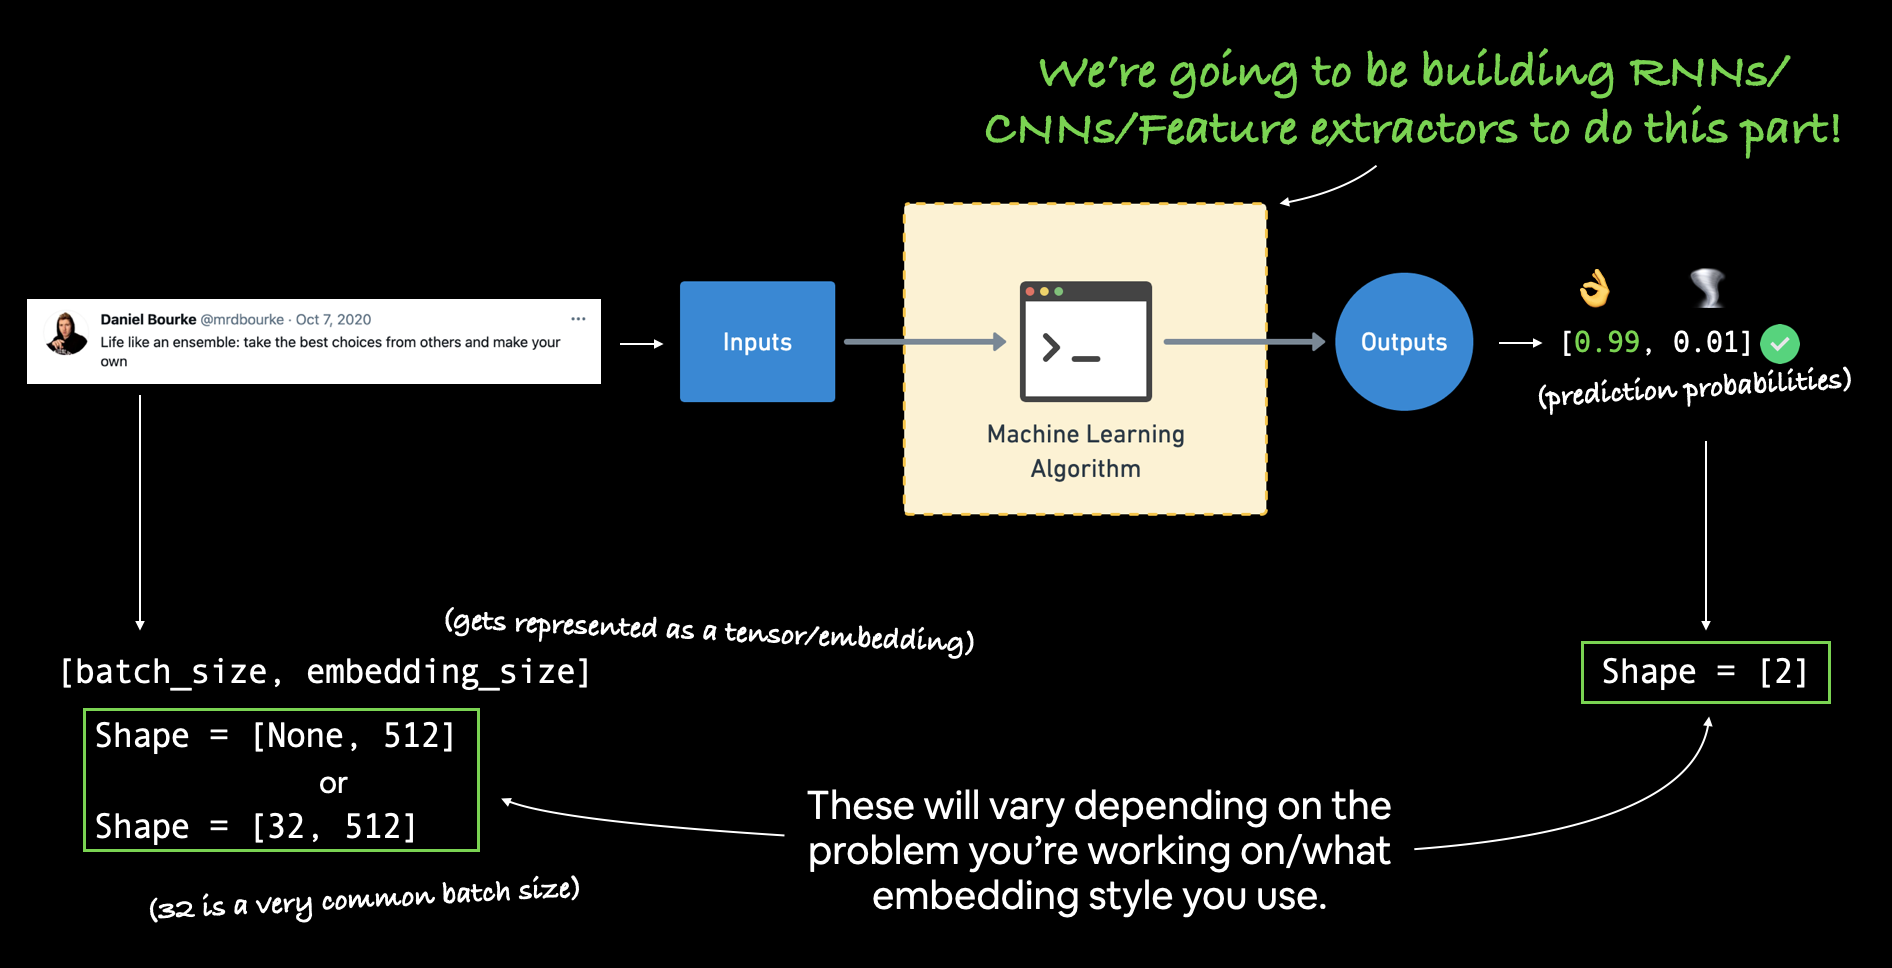

Model 0: Naive Bayes

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0=Pipeline([
    ("tfidf", TfidfVectorizer()),  # Convert text to TF-IDF]
    ("clf", MultinomialNB())  # Classifier
])

model_0.fit(train_sentences, train_labels)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [27]:
model_0.score(val_sentences, val_labels)

0.7926509186351706

In [28]:
model_0.predict(["I love TensorFlow!"])

array([0])

Creating an evaluation for our model experiments


In [31]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,precision_recall_fscore_support

def calculate_results(y_true,y_pred):
    model_accuracy=accuracy_score(y_true, y_pred)*100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results={
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall, 
        "f1": model_f1
    }
    return model_results

In [32]:
baseline_model_results=calculate_results(val_labels, model_0.predict(val_sentences))
baseline_model_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}